# Parameter Estimation

In [ ]:
!pip install pytorch_lightning
!pip install wandb

In [ ]:
import torch  # pip install
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform

import pytorch_lightning  # pip install
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

import numpy as np
import matplotlib.pyplot as plt

import wandb  # pip install

PATH_DATASETS = "."
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 1024 if AVAIL_GPUS else 64

In [ ]:
AVAIL_GPUS

1

In [ ]:
pytorch_lightning.seed_everything(333)

INFO:lightning_fabric.utilities.seed:Seed set to 333


333

## 01. Generate data

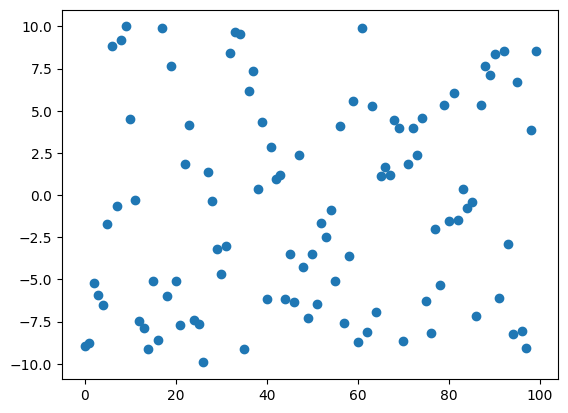

In [ ]:
np.random.uniform(-10,10,10)
plt.scatter(np.arange(100),np.random.uniform(-10,10,100))

In [ ]:
def generate_data(n_samples, x_range):
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=n_samples)

    a = 3.0
    b = -2.0
    c = 5.0

    eps = np.random.randn(n_samples) * 0.1

    y = a * np.sin(x) + b * np.sqrt(x) + c + eps

    x = x.reshape((n_samples,1))
    y = y.reshape((n_samples,1))

    # Convert to pytorch tensors
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)


    return x,y

In [ ]:
class data_loader(Dataset):  # Dataset 은 torch.utils.data 에 있는 클래스
    def __init__(self,x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)  # 단일 정수값을 반환해야 함

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx,:]

In [ ]:
x,y = generate_data(10_000, (0,10))

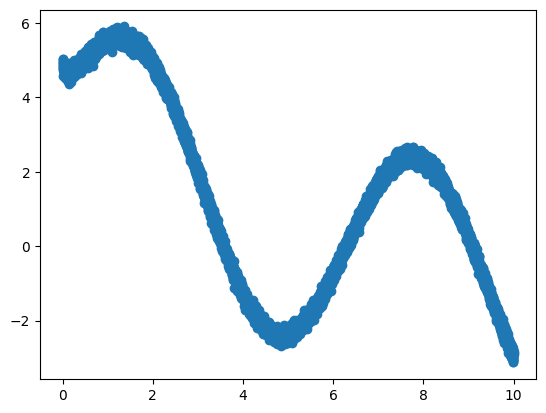

In [ ]:
plt.scatter(x,y, '.')

: why doesn't any negative value of x show?

## MLP

In [ ]:
class MLP(LightningModule):
    def __init__(self, batch_size: int = 1024, hidden_layer=5, hidden_depth=5, lr=0.01):
        super(MLP, self).__init__() # 상속받은 class "nn.Module" 안에서 모델이 훈련되는 동안 업데이트 될 파라미터들을 정의

        self.hidden_layer = hidden_layer
        self.hidden_depth = hidden_depth
        self.lr = lr

        self.a = nn.Parameter(torch.rand(1), requires_grad=True)
        self.b = nn.Parameter(torch.rand(1), requires_grad=True)
        self.c = nn.Parameter(torch.rand(1), requires_grad=True)

        self.batch_size = batch_size

        self.ds_train = None # 이 데이터set 은 아래에서 정의하고 이를 위해 미리 initialization
        self.ds_val = None

        # layers = [
        #     nn.Linear(1, hidden_layer),  # nn.Linear(input_features, out_features)
        #     nn.ReLU()
        # ]
        # for i in range(hidden_depth):
        #     layers.extend([
        #         nn.Linear(hidden_layer, hidden_layer),
        #         nn.ReLU()
        #     ])

        # layers.append(nn.Linear(hidden_layer, 1))

        # self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.a * torch.sin(x) + self.b * torch.sqrt(x) + self.c

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('a', self.a, prog_bar=True)
        self.log('b', self.b, prog_bar=True)
        self.log('c', self.c, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def prepare_data(self):
        train_x, train_y = generate_data(10_000, x_range=(0,10))
        val_x,  val_y = generate_data(3000, x_range=(0,15))
        self.ds_train = data_loader(train_x, train_y)
        self.ds_val = data_loader(val_x, val_y)

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size, num_workers=1)  # num_workers를 1 또는 그 이상으로 설정하면 데이터 로딩 속도가 향상

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size, num_workers=1)

In [ ]:
model = MLP(lr=0.1)

wandb_logger = WandbLogger(
    project="parameter_estimation_MLP"
)

trainer = Trainer(
    logger=wandb_logger,
    accelerator="cuda",
    devices=AVAIL_GPUS,
    max_epochs=100
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
#wandb.login()

In [ ]:
trainer.fit(model)

wandb: Currently logged in as: hiilynn. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 3     
--------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.save_checkpoint('parameter_estimation_MLP.pth')
wandb.save('parameter_estimation_MLP.pth')

['./wandb/run-20231122_072359-qy1ep8hm/files/parameter_estimation_MLP.pth']